# Forecasting Future Sales Using XGBRegressor AND LightGBM


**Data fields**

- **date** - Date of the sale data. There are no holiday effects or store closures.
- **store** - Store ID
- **item** - Item ID
- **sales** - Number of items sold at a particular store on a particular date.

# Importing Basic Libraries and Loading Dataset

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

import warnings
warnings.filterwarnings("ignore")

In [24]:
data = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


# Understanding Dataset

In [25]:
data.shape

(913000, 4)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Let's convert data columns to datetime type:

In [27]:
from datetime import datetime, timedelta, date

data['date'] = pd.to_datetime(data['date'])

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


No null value and no duplicate row:

In [29]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [31]:
data['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [32]:
data['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

Let's calculate the total daily, monthly and annual sales:

In [33]:
For_day= data.date.apply(lambda x: str(x)[:-9])
For_day

0         2013-01-01
1         2013-01-02
2         2013-01-03
3         2013-01-04
4         2013-01-05
             ...    
912995    2017-12-27
912996    2017-12-28
912997    2017-12-29
912998    2017-12-30
912999    2017-12-31
Name: date, Length: 913000, dtype: object

In [34]:
For_month= data.date.apply(lambda x: str(x)[:-12])
For_month

0         2013-01
1         2013-01
2         2013-01
3         2013-01
4         2013-01
           ...   
912995    2017-12
912996    2017-12
912997    2017-12
912998    2017-12
912999    2017-12
Name: date, Length: 913000, dtype: object

In [35]:
For_year= data.date.apply(lambda x: str(x)[:4])
For_year

0         2013
1         2013
2         2013
3         2013
4         2013
          ... 
912995    2017
912996    2017
912997    2017
912998    2017
912999    2017
Name: date, Length: 913000, dtype: object

Let's create a function:

In [36]:
def sales_D_M_or_Y(df, time=["daily", 'monthly','yearly']):
    df= df.copy()
    if time == "daily":
        df.date= df.date.apply(lambda x: str(x)[:-9])
    elif time == "monthly":
        # Drop the day and hour indicators from the date column:
        df.date= df.date.apply(lambda x: str(x)[:-12])
    else:
        df.date= df.date.apply(lambda x: str(x)[:4])
        
   
    df= df.groupby('date')['sales'].sum().reset_index()
    df.date= pd.to_datetime(df.date)
        
    return df

Daily sales:

In [37]:
df_day= sales_D_M_or_Y(data, "daily")
df_day.head()

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


1826 days

In [38]:
df_day.shape

(1826, 2)

Monthly sales:

In [39]:
df_month= sales_D_M_or_Y(data, "monthly")
df_month.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [40]:
df_month.shape

(60, 2)

Annual sales:

In [41]:
df_year= sales_D_M_or_Y(data, "yearly")
df_year.head()

,date,sales
0,2013-01-01,7941243
1,2014-01-01,9135482
2,2015-01-01,9536887
3,2016-01-01,10357160
4,2017-01-01,10733740


In [42]:
df_year.shape

(5, 2)

We will forecast daily total sales. So, we will go with df_day data frame. Let's make the index the "date" column:

In [43]:
df_day= df_day.set_index('date')

# EDA

<AxesSubplot:xlabel='date'>

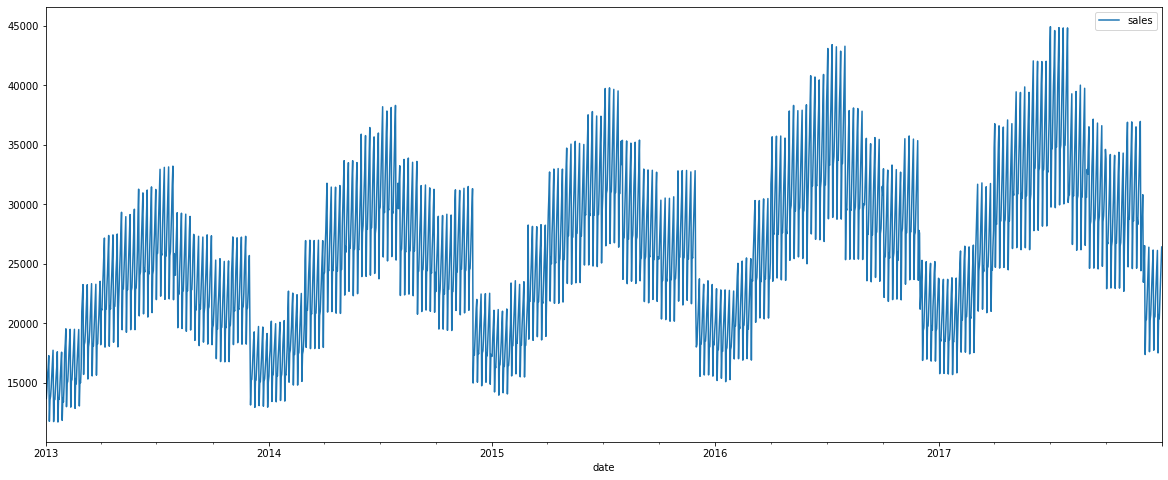

In [44]:
df_day.plot(figsize=(20, 8))

# Feture Engineering

**Date time features**

Date time features are features created from the time stamp value of each observation. Let's create them:

In [45]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    return df

In [46]:
df2= create_date_time_features(df_day)
df2

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1
2013-01-02,13678,2,1,1,2013,2,2,1
2013-01-03,14488,3,1,1,2013,3,3,1
2013-01-04,15677,4,1,1,2013,4,4,1
2013-01-05,16237,5,1,1,2013,5,5,1
...,...,...,...,...,...,...,...,...
2017-12-27,20378,2,4,12,2017,361,27,52
2017-12-28,21885,3,4,12,2017,362,28,52
2017-12-29,23535,4,4,12,2017,363,29,52


In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sales       1826 non-null   int64
 1   dayofweek   1826 non-null   int64
 2   quarter     1826 non-null   int64
 3   month       1826 non-null   int64
 4   year        1826 non-null   int64
 5   dayofyear   1826 non-null   int64
 6   dayofmonth  1826 non-null   int64
 7   weekofyear  1826 non-null   int64
dtypes: int64(8)
memory usage: 128.4 KB


**Lag features and window features**

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future. For example, it can be beneficial to generate features for sales that happened in previous days at 4:00 p.m. if you want to predict similar sales at 4:00 p.m. the next day

In [48]:
df3= df2.copy()

Adding differences with the previous day:

In [49]:
def add_diff(df, diff_column):
    df['prev_sales'] = df[diff_column].shift(1)
    df['diff']= (df[diff_column] - df['prev_sales'])
    return df

In [50]:
add_diff(df3, 'sales')

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prev_sales,diff
date,,,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1,NaN,NaN
2013-01-02,13678,2,1,1,2013,2,2,1,13696.0,-18.0
2013-01-03,14488,3,1,1,2013,3,3,1,13678.0,810.0
2013-01-04,15677,4,1,1,2013,4,4,1,14488.0,1189.0
2013-01-05,16237,5,1,1,2013,5,5,1,15677.0,560.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,2,4,12,2017,361,27,52,20738.0,-360.0
2017-12-28,21885,3,4,12,2017,362,28,52,20378.0,1507.0
2017-12-29,23535,4,4,12,2017,363,29,52,21885.0,1650.0


Adding same day sales from previous years...

In [51]:
df4= df3.copy()

In [52]:
from dateutil.relativedelta import relativedelta, MO

def add_lag_columns(df):
    total_year= relativedelta(df.index.max(), df.index.min()).years
    for column in range(1, total_year+1):
        column_name = 'lag_' + str(column)
        df[column_name]= ""
        df[column_name] = pd.to_numeric(df[column_name])

In [53]:
add_lag_columns(df4)

In [54]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       1826 non-null   int64  
 1   dayofweek   1826 non-null   int64  
 2   quarter     1826 non-null   int64  
 3   month       1826 non-null   int64  
 4   year        1826 non-null   int64  
 5   dayofyear   1826 non-null   int64  
 6   dayofmonth  1826 non-null   int64  
 7   weekofyear  1826 non-null   int64  
 8   prev_sales  1825 non-null   float64
 9   diff        1825 non-null   float64
 10  lag_1       0 non-null      float64
 11  lag_2       0 non-null      float64
 12  lag_3       0 non-null      float64
 13  lag_4       0 non-null      float64
dtypes: float64(6), int64(8)
memory usage: 214.0 KB


Adding lag values...

In [55]:
def add_lag_values(df, target):
    for count in range(0, len(df.index)):
        for column in ["lag_1", "lag_2", "lag_3", "lag_4"]:
            if column=="lag_1":
                #startValue= df.iloc[count,  list(df.columns).index(target)]
                date= df.index[count] - relativedelta(years=1)#same day 1 year ago
                if date>=df.index.min():
                    pValue  = df.loc[date][list(df.columns).index(target)]
                    df.iloc[count, list(df.columns).index(column)]= pValue
                else:
                    break
            elif column=="lag_2":
                #startValue= df.iloc[count,  list(df.columns).index(target)]
                date= df.index[count] - relativedelta(years=2)#same day 2 years ago
                if date>=df.index.min():
                    pValue  = df.loc[date][list(df.columns).index(target)]
                    df.iloc[count, list(df.columns).index(column)]= pValue
                else:
                    break   
            elif column=="lag_3":
                #startValue= df.iloc[count,  list(df.columns).index(target)]
                date= df.index[count] - relativedelta(years=3)
                if date>=df.index.min():
                    pValue  = df.loc[date][list(df.columns).index(target)]
                    df.iloc[count, list(df.columns).index(column)]= pValue
                else:
                    break  
            else:
                #startValue= df.iloc[count,  list(df.columns).index(target)]
                date= df.index[count] - relativedelta(years=4)
                if date>=df.index.min():
                    pValue  = df.loc[date][list(df.columns).index(target)]
                    df.iloc[count, list(df.columns).index(column)]= pValue
                else:
                    break
    return df
    #df.dropna(inplace=True)
    #return df

In [56]:
%%time
add_lag_values(df4, "sales")

CPU times: user 2.28 s, sys: 5.56 ms, total: 2.28 s
Wall time: 2.28 s


,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prev_sales,diff,lag_1,lag_2,lag_3,lag_4
date,,,,,,,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,13678,2,1,1,2013,2,2,1,13696.0,-18.0,NaN,NaN,NaN,NaN
2013-01-03,14488,3,1,1,2013,3,3,1,13678.0,810.0,NaN,NaN,NaN,NaN
2013-01-04,15677,4,1,1,2013,4,4,1,14488.0,1189.0,NaN,NaN,NaN,NaN
2013-01-05,16237,5,1,1,2013,5,5,1,15677.0,560.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,2,4,12,2017,361,27,52,20738.0,-360.0,19341.0,23268.0,21317.0,17047.0
2017-12-28,21885,3,4,12,2017,362,28,52,20378.0,1507.0,19560.0,15569.0,22532.0,18433.0
2017-12-29,23535,4,4,12,2017,363,29,52,21885.0,1650.0,21111.0,18403.0,14888.0,19148.0


some checks are done:

In [57]:
df4.loc["2013-12-31"]["sales"]==df4.loc["2017-12-31"]["lag_4"]

True

In [58]:
df4.loc["2014-12-31"]["sales"]==df4.loc["2017-12-31"]["lag_3"]

True

Now let's create the general data frame that we will use for forecasting:

In [59]:
df_model= df4.drop(['prev_sales'], axis=1)
df_model

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4
date,,,,,,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN
2013-01-02,13678,2,1,1,2013,2,2,1,-18.0,NaN,NaN,NaN,NaN
2013-01-03,14488,3,1,1,2013,3,3,1,810.0,NaN,NaN,NaN,NaN
2013-01-04,15677,4,1,1,2013,4,4,1,1189.0,NaN,NaN,NaN,NaN
2013-01-05,16237,5,1,1,2013,5,5,1,560.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,2,4,12,2017,361,27,52,-360.0,19341.0,23268.0,21317.0,17047.0
2017-12-28,21885,3,4,12,2017,362,28,52,1507.0,19560.0,15569.0,22532.0,18433.0
2017-12-29,23535,4,4,12,2017,363,29,52,1650.0,21111.0,18403.0,14888.0,19148.0


In [60]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       1826 non-null   int64  
 1   dayofweek   1826 non-null   int64  
 2   quarter     1826 non-null   int64  
 3   month       1826 non-null   int64  
 4   year        1826 non-null   int64  
 5   dayofyear   1826 non-null   int64  
 6   dayofmonth  1826 non-null   int64  
 7   weekofyear  1826 non-null   int64  
 8   diff        1825 non-null   float64
 9   lag_1       1461 non-null   float64
 10  lag_2       1096 non-null   float64
 11  lag_3       731 non-null    float64
 12  lag_4       365 non-null    float64
dtypes: float64(5), int64(8)
memory usage: 264.3 KB


# Splitting Train and Test

The last 1 year's sales data in the dataset will be used for the test.

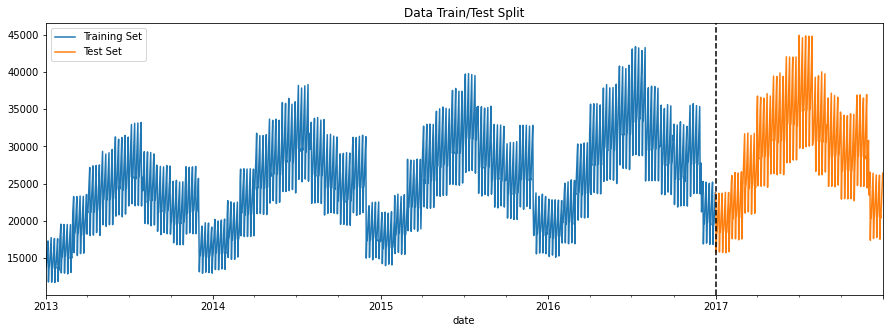

In [61]:
train= df_model.loc[df_model.index < '2017-01-01']
test = df_model.loc[df_model.index >= '2017-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
df_day.loc[df_day.index < '2017-01-01'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
df_day.loc[df_day.index >= '2017-01-01'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [62]:
df_model.columns

Index(['sales', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4'],
      dtype='object')

In [63]:
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4']

TARGET = 'sales'

In [64]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Building and Running XGB Regressor

In [85]:
import xgboost as xgb
import lightgbm as lgb

In [86]:
model= xgb.XGBRegressor(random_state=51)
model2=lgb.LGBMRegressor(random_state=51)

In [67]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

In [68]:
%%time
start = time()
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time()-start    
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (MAE):", mean_absolute_error(y_test, y_pred))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print()

[0]	validation_0-rmse:18359.37313	validation_1-rmse:21557.12211
[99]	validation_0-rmse:66.00125	validation_1-rmse:1833.92369
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
	Training time: 0.780s
	Prediction time: 0.007s
	Explained variance: 0.9399700531951362
	Mean absolute error (MAE): 1427.1896002782535
	Root Mean squared error (RMSE): 1833.923694383487


Metrics:
- Explained variance: 0.9399700531951362
- Mean absolute error (MAE): 1427.1896002782535
- Root Mean squared error (RMSE): 1833.923694383487
- R2 score: 0.9205195289281972

# Building LightGBM model

In [89]:
%%time
start = time()
model2.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)
train_time = time() - start
start = time()
y_pred = model2.predict(X_test)
predict_time = time()-start    
print(model2)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (MAE):", mean_absolute_error(y_test, y_pred))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print()

[100]	training's l2: 41125.5	valid_1's l2: 2.7542e+06
LGBMRegressor(random_state=51)
	Training time: 0.205s
	Prediction time: 0.004s
	Explained variance: 0.9496588698005484
	Mean absolute error (MAE): 1295.3809178012373
	Root Mean squared error (RMSE): 1659.577299863839
	R2 score: 0.9349132058696894

CPU times: user 800 ms, sys: 23.9 ms, total: 824 ms
Wall time: 212 ms


# EXPLAINED VARIANCE or RMSE is used as evaluation metric
WE SEEK EXPLAINED VARIANCE TO BE CLOSER TO 1

# Cross Validation

In [69]:
from sklearn.model_selection import cross_val_score
Cross_validation_score= round(np.mean(cross_val_score(model, X_train, y_train, cv=10)), 3)
Cross_validation_score

0.847

In [91]:
Cross_validation_score2= round(np.mean(cross_val_score(model2, X_train, y_train, cv=10)), 3)
Cross_validation_score2

0.844

# Using our best model

In [71]:
best_model= xgb.XGBRegressor(colsample_bytree= 0.3, learning_rate= 0.1, max_depth= 3, n_estimators= 1000)

start = time()
best_model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)
train_time = time() - start
start = time()
y_pred = best_model.predict(X_test)
predict_time = time()-start    
print(best_model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (MAE):", mean_absolute_error(y_test, y_pred))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print()

[0]	validation_0-rmse:23505.50227	validation_1-rmse:27478.85642
[100]	validation_0-rmse:504.54327	validation_1-rmse:1269.51306
[200]	validation_0-rmse:314.11586	validation_1-rmse:1155.00497
[300]	validation_0-rmse:241.16207	validation_1-rmse:1109.50220
[400]	validation_0-rmse:201.58003	validation_1-rmse:1090.81639
[500]	validation_0-rmse:175.63887	validation_1-rmse:1080.49152
[600]	validation_0-rmse:154.81190	validation_1-rmse:1071.97082
[700]	validation_0-rmse:140.87442	validation_1-rmse:1068.19101
[800]	validation_0-rmse:128.48446	validation_1-rmse:1068.85412
[900]	validation_0-rmse:119.14449	validation_1-rmse:1066.92249
[999]	validation_0-rmse:111.76649	validation_1-rmse:1066.18164
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_

# EXPLAINED VARIANCE = 0.9855 AND RMSE = 1066.18


# Test Data Predictions

Now, time to test our model on the test dataset.

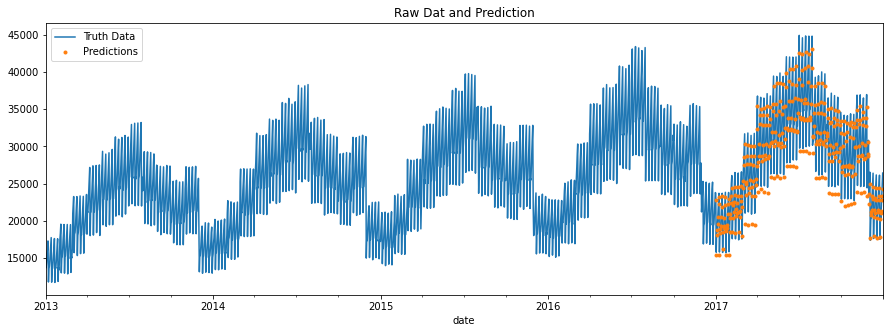

In [72]:
test['prediction']= best_model.predict(X_test)

df_result= df_model.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_result[['sales']].plot(figsize=(15, 5))
df_result['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [73]:
df_result

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4,prediction
date,,,,,,,,,,,,,,
2013-01-01,13696,1,1,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,13678,2,1,1,2013,2,2,1,-18.0,NaN,NaN,NaN,NaN,NaN
2013-01-03,14488,3,1,1,2013,3,3,1,810.0,NaN,NaN,NaN,NaN,NaN
2013-01-04,15677,4,1,1,2013,4,4,1,1189.0,NaN,NaN,NaN,NaN,NaN
2013-01-05,16237,5,1,1,2013,5,5,1,560.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,2,4,12,2017,361,27,52,-360.0,19341.0,23268.0,21317.0,17047.0,20998.773438
2017-12-28,21885,3,4,12,2017,362,28,52,1507.0,19560.0,15569.0,22532.0,18433.0,21302.744141
2017-12-29,23535,4,4,12,2017,363,29,52,1650.0,21111.0,18403.0,14888.0,19148.0,23300.826172


**Feature importances**

Which features are the most important in the regression calculation?

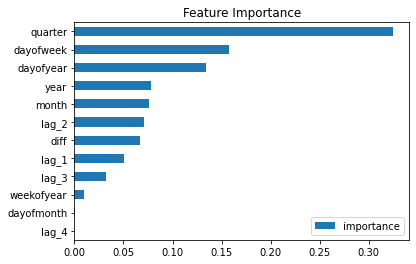

In [74]:
fi= pd.DataFrame(data   = best_model.feature_importances_,
                 index  = model.feature_names_in_,
                 columns= ['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

# Forecast of Future Sales

Now it's time to realize our main objective: Forecast Future Sales. 

We will forecast 1-year sales data as daily.

Last day in our dataset:

In [75]:
df_day.index.max()

Timestamp('2017-12-31 00:00:00')

Let's create a data frame including 1 year later from the last day in our dataset

In [76]:
future= pd.date_range(df_day.index.max()+relativedelta(days=1),
                      df_day.index.max()+relativedelta(years=1), 
                      freq='1d')
future_df= pd.DataFrame(index=future)
future_df

""
2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-01-05
...
2018-12-27
2018-12-28
2018-12-29
2018-12-30


In [77]:
future_df['isFuture'] = True
df_model['isFuture'] = False
df_and_future = pd.concat([df_model, future_df])
df_and_future

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4,isFuture
2013-01-01,13696.0,1.0,1.0,1.0,2013.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,False
2013-01-02,13678.0,2.0,1.0,1.0,2013.0,2.0,2.0,1.0,-18.0,NaN,NaN,NaN,NaN,False
2013-01-03,14488.0,3.0,1.0,1.0,2013.0,3.0,3.0,1.0,810.0,NaN,NaN,NaN,NaN,False
2013-01-04,15677.0,4.0,1.0,1.0,2013.0,4.0,4.0,1.0,1189.0,NaN,NaN,NaN,NaN,False
2013-01-05,16237.0,5.0,1.0,1.0,2013.0,5.0,5.0,1.0,560.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


again feature engineering...

In [78]:
df_and_future= create_date_time_features(df_and_future)
df_and_future

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4,isFuture
2013-01-01,13696.0,1,1,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,False
2013-01-02,13678.0,2,1,1,2013,2,2,1,-18.0,NaN,NaN,NaN,NaN,False
2013-01-03,14488.0,3,1,1,2013,3,3,1,810.0,NaN,NaN,NaN,NaN,False
2013-01-04,15677.0,4,1,1,2013,4,4,1,1189.0,NaN,NaN,NaN,NaN,False
2013-01-05,16237.0,5,1,1,2013,5,5,1,560.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,3,4,12,2018,361,27,52,NaN,NaN,NaN,NaN,NaN,True
2018-12-28,NaN,4,4,12,2018,362,28,52,NaN,NaN,NaN,NaN,NaN,True
2018-12-29,NaN,5,4,12,2018,363,29,52,NaN,NaN,NaN,NaN,NaN,True
2018-12-30,NaN,6,4,12,2018,364,30,52,NaN,NaN,NaN,NaN,NaN,True


In [79]:
df_and_future= add_lag_values(df_and_future, "sales")
df_and_future

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4,isFuture
2013-01-01,13696.0,1,1,1,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,False
2013-01-02,13678.0,2,1,1,2013,2,2,1,-18.0,NaN,NaN,NaN,NaN,False
2013-01-03,14488.0,3,1,1,2013,3,3,1,810.0,NaN,NaN,NaN,NaN,False
2013-01-04,15677.0,4,1,1,2013,4,4,1,1189.0,NaN,NaN,NaN,NaN,False
2013-01-05,16237.0,5,1,1,2013,5,5,1,560.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,3,4,12,2018,361,27,52,NaN,20378.0,19341.0,23268.0,21317.0,True
2018-12-28,NaN,4,4,12,2018,362,28,52,NaN,21885.0,19560.0,15569.0,22532.0,True
2018-12-29,NaN,5,4,12,2018,363,29,52,NaN,23535.0,21111.0,18403.0,14888.0,True
2018-12-30,NaN,6,4,12,2018,364,30,52,NaN,24988.0,22296.0,18191.0,17407.0,True


data frame we will forecast:

In [80]:
future_w_features= df_and_future.query('isFuture').copy()
future_w_features

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,diff,lag_1,lag_2,lag_3,lag_4,isFuture
2018-01-01,NaN,0,1,1,2018,1,1,1,NaN,23709.0,20158.0,17226.0,15556.0,True
2018-01-02,NaN,1,1,1,2018,2,2,1,NaN,15772.0,21280.0,18719.0,17033.0,True
2018-01-03,NaN,2,1,1,2018,3,3,1,NaN,18650.0,22911.0,19798.0,17746.0,True
2018-01-04,NaN,3,1,1,2018,4,4,1,NaN,18510.0,15199.0,21101.0,19184.0,True
2018-01-05,NaN,4,1,1,2018,5,5,1,NaN,19895.0,17806.0,14235.0,20182.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,3,4,12,2018,361,27,52,NaN,20378.0,19341.0,23268.0,21317.0,True
2018-12-28,NaN,4,4,12,2018,362,28,52,NaN,21885.0,19560.0,15569.0,22532.0,True
2018-12-29,NaN,5,4,12,2018,363,29,52,NaN,23535.0,21111.0,18403.0,14888.0,True
2018-12-30,NaN,6,4,12,2018,364,30,52,NaN,24988.0,22296.0,18191.0,17407.0,True


and forecasts:

In [81]:
future_w_features['forecast'] = best_model.predict(future_w_features[FEATURES])
future_w_features['forecast']

2018-01-01    17307.154297
2018-01-02    18528.173828
2018-01-03    19536.250000
2018-01-04    19385.193359
2018-01-05    20601.164062
                  ...     
2018-12-27    20689.853516
2018-12-28    22348.037109
2018-12-29    23171.615234
2018-12-30    25487.335938
2018-12-31    19484.886719
Name: forecast, Length: 365, dtype: float32

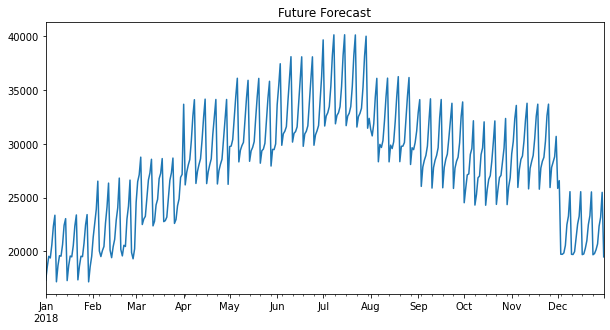

In [82]:
future_w_features['forecast'].plot(figsize=(10, 5),
                                   title='Future Forecast')
plt.show()